In [ ]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exploring the Dataset

In [ ]:
import os
import shutil
import random
import zipfile

from sklearn.model_selection import train_test_split

zip_path = '/content/drive/MyDrive/machine learning datasets/tumor_and_parkinsons.zip'
extracted_dir = '/content/datas'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

In [ ]:
from PIL import Image

dataset_path = '/content/datas/tumor_and_parkinsons/parkinsons'

image_sizes = []

for file_name in os.listdir(dataset_path):
  file_path = os.path.join(dataset_path, file_name)
  if os.path.isfile(file_path):
    with Image.open(file_path) as img:
      #print(img.size)
      image_sizes.append((file_name, img.size,img.mode))

# Print image sizes
for file_name, size,num_channels in image_sizes:
  print(f"Image '{file_name}' size: {size[0]} x {size[1]} pixels, , Channels: {num_channels}")

Image '2 .jpg' size: 712 x 453 pixels, , Channels: RGB
Image '11 .jpg' size: 712 x 453 pixels, , Channels: RGB
Image '1 .jpg' size: 712 x 453 pixels, , Channels: RGB
Image '31 .jpg' size: 712 x 453 pixels, , Channels: RGB
Image '41 .jpg' size: 712 x 453 pixels, , Channels: RGB
Image '6 .jpg' size: 712 x 453 pixels, , Channels: RGB
Image '35 .jpg' size: 712 x 453 pixels, , Channels: RGB
Image '12 .jpg' size: 712 x 453 pixels, , Channels: RGB
Image '40 .jpg' size: 712 x 453 pixels, , Channels: RGB
Image '14 .jpg' size: 712 x 453 pixels, , Channels: RGB
Image '18 .jpg' size: 712 x 453 pixels, , Channels: RGB
Image '29 .jpg' size: 712 x 453 pixels, , Channels: RGB
Image '34 .jpg' size: 712 x 453 pixels, , Channels: RGB
Image '23 .jpg' size: 712 x 453 pixels, , Channels: RGB
Image '36 .jpg' size: 712 x 453 pixels, , Channels: RGB
Image '5 .jpg' size: 712 x 453 pixels, , Channels: RGB
Image '16 .jpg' size: 712 x 453 pixels, , Channels: RGB
Image '4 .jpg' size: 712 x 453 pixels, , Channels: R

## Creating training, validation and testing datasets


In [ ]:
dataset_path = '/content/datas/tumor_and_parkinsons'
image_size = (512,512)
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   validation_split=0.3,
                                   rotation_range=20, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True, 
                                   vertical_flip=False)
train_batches = train_datagen.flow_from_directory(dataset_path, target_size=image_size, batch_size = batch_size, class_mode='categorical', subset='training',shuffle=True)
validation_batches = train_datagen.flow_from_directory(dataset_path, target_size=image_size, batch_size = batch_size, class_mode='categorical', subset='validation',shuffle=True)
test_batches = train_datagen.flow_from_directory(dataset_path, target_size=image_size, batch_size = batch_size, class_mode='categorical', shuffle=False, subset='validation')

Found 208 images belonging to 3 classes.
Found 87 images belonging to 3 classes.
Found 87 images belonging to 3 classes.


## CNN model with 3 layers

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_batches.num_classes, activation='softmax')
])


## Training the model

In [ ]:
# Compiling the model

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the model
epochs = 20
history = model.fit(train_batches, epochs=epochs, validation_data=validation_batches)

Epoch 1/20
13/13 [==============================] - 36s 3s/step - loss: 2.8245 - accuracy: 0.4663 - val_loss: 0.7592 - val_accuracy: 0.6092
Epoch 2/20
13/13 [==============================] - 20s 2s/step - loss: 0.8858 - accuracy: 0.5481 - val_loss: 0.7471 - val_accuracy: 0.6207
Epoch 3/20
13/13 [==============================] - 21s 2s/step - loss: 0.8025 - accuracy: 0.5817 - val_loss: 0.7028 - val_accuracy: 0.6552
Epoch 4/20
13/13 [==============================] - 20s 2s/step - loss: 0.6455 - accuracy: 0.7019 - val_loss: 0.7336 - val_accuracy: 0.6897
Epoch 5/20
13/13 [==============================] - 23s 2s/step - loss: 0.7457 - accuracy: 0.6683 - val_loss: 0.6371 - val_accuracy: 0.7241
Epoch 6/20
13/13 [==============================] - 19s 2s/step - loss: 0.6314 - accuracy: 0.7308 - val_loss: 0.6230 - val_accuracy: 0.7126
Epoch 7/20
13/13 [==============================] - 21s 2s/step - loss: 0.5889 - accuracy: 0.7452 - val_loss: 0.6013 - val_accuracy: 0.7471
Epoch 8/20
13/13 [==

## Results

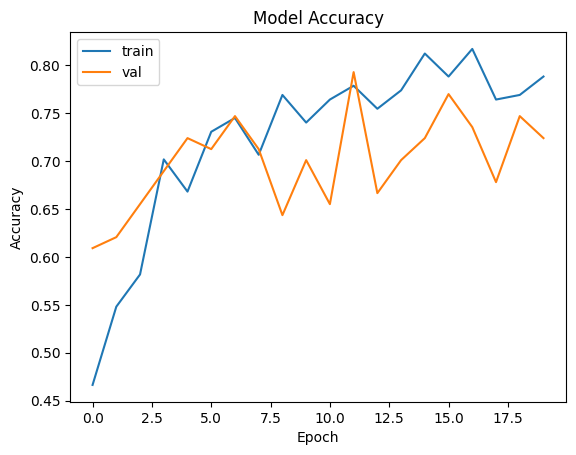

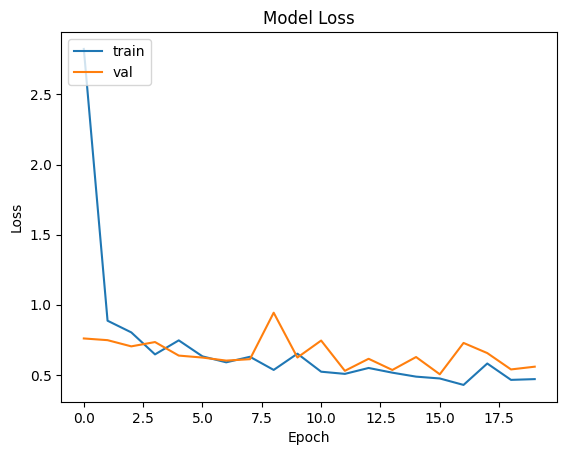

In [ ]:
import matplotlib.pyplot as plt

# Getting the training and validation metrics over epochs
accu1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']

# Plotting accuracy over epochs
plt.plot(accu1)
plt.plot(val_acc1)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss over epochs
plt.plot(loss1)
plt.plot(val_loss1)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, cohen_kappa_score

test_pred = model.predict(test_batches)
test_labels = test_batches.classes

acc1 = accuracy_score(test_labels, np.argmax(test_pred, axis=-1))

prec1 = precision_score(test_labels, np.argmax(test_pred, axis=-1), average='weighted')

f11 = f1_score(test_labels, np.argmax(test_pred, axis=-1), average='weighted')

sensitivity1 = recall_score(test_labels, np.argmax(test_pred, axis=-1), average='weighted')

auc1 = roc_auc_score(test_batches.labels, test_pred, multi_class='ovr', average='weighted')

kappa1 = cohen_kappa_score(test_labels, np.argmax(test_pred, axis=-1))


6/6 [==============================] - 7s 1s/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, np.argmax(test_pred, axis=-1)))
print("Validation Accuracy of the model: ",acc1)
print("Precision of the model: ",prec1)
print("f1 score of the model: ",f11)
print("Recall score of the model: ",sensitivity1)
print("AUC of the model: ",auc1)
print("Kappa of the model: ",kappa1)

              precision    recall  f1-score   support

           0       0.59      0.55      0.57        29
           1       1.00      0.83      0.91        12
           2       0.72      0.78      0.75        46

    accuracy                           0.71        87
   macro avg       0.77      0.72      0.74        87
weighted avg       0.72      0.71      0.71        87

Validation Accuracy of the model:  0.7126436781609196
Precision of the model:  0.7161515538527032
f1 score of the model:  0.712419764143902
Recall score of the model:  0.7126436781609196
AUC of the model:  0.8442910588440011
Kappa of the model:  0.5018323408153917


## CNN with kernel regulizer

Using "hinge" loss

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,Flatten
from tensorflow.keras.regularizers import l1

In [ ]:
model2 = Sequential()
model2.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3, strides = 2,input_shape=(512,512,3)))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Conv2D(filters = 64, padding = "same",activation = "relu",kernel_size=3))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Conv2D(filters = 128, padding = "same",activation = "relu",kernel_size=3))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Flatten())
model2.add(Dense(128,activation="relu"))
model2.add(Dropout(0.5))
#Output layer
model2.add(Dense(3,kernel_regularizer=l1(0.001),activation = "linear"))

model2.compile(optimizer = 'adam', loss = "hinge", metrics = ['accuracy'])

history = model2.fit(train_batches, epochs= 20,validation_data=validation_batches)

Epoch 1/20
13/13 [==============================] - 24s 2s/step - loss: 1.0161 - accuracy: 0.4567 - val_loss: 0.6596 - val_accuracy: 0.5862
Epoch 2/20
13/13 [==============================] - 19s 2s/step - loss: 0.6376 - accuracy: 0.5817 - val_loss: 0.5502 - val_accuracy: 0.6092
Epoch 3/20
13/13 [==============================] - 21s 2s/step - loss: 0.6258 - accuracy: 0.6154 - val_loss: 0.5548 - val_accuracy: 0.6322
Epoch 4/20
13/13 [==============================] - 25s 2s/step - loss: 0.6054 - accuracy: 0.6779 - val_loss: 0.6520 - val_accuracy: 0.5747
Epoch 5/20
13/13 [==============================] - 20s 2s/step - loss: 0.6101 - accuracy: 0.6683 - val_loss: 0.5394 - val_accuracy: 0.6782
Epoch 6/20
13/13 [==============================] - 21s 2s/step - loss: 0.5089 - accuracy: 0.6827 - val_loss: 0.5058 - val_accuracy: 0.7011
Epoch 7/20
13/13 [==============================] - 20s 2s/step - loss: 0.4883 - accuracy: 0.7356 - val_loss: 0.7417 - val_accuracy: 0.6207
Epoch 8/20
13/13 [==

## Results

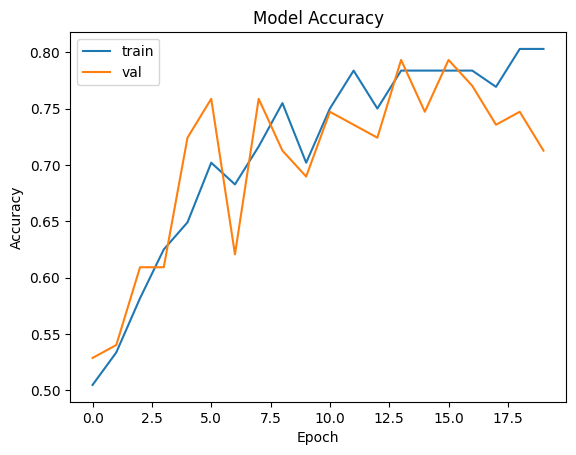

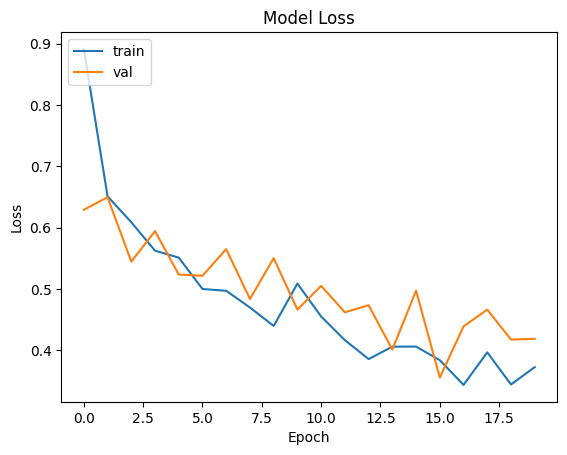

In [ ]:
import matplotlib.pyplot as plt

# Getting the training and validation metrics over epochs
acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

# Plotting accuracy over epochs
plt.plot(acc2)
plt.plot(val_acc2)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Ploting loss over epochs
plt.plot(loss2)
plt.plot(val_loss2)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, cohen_kappa_score
from sklearn.metrics import classification_report
test_pred = model2.predict(test_batches)
test_labels = test_batches.classes

acc = accuracy_score(test_labels, np.argmax(test_pred, axis=-1))

prec = precision_score(test_labels, np.argmax(test_pred, axis=-1), average='weighted')

f1 = f1_score(test_labels, np.argmax(test_pred, axis=-1), average='weighted')

sensitivity = recall_score(test_labels, np.argmax(test_pred, axis=-1), average='weighted')

#auc = roc_auc_score(test_batches.labels, test_pred, multi_class='ovr', average='weighted')

kappa = cohen_kappa_score(test_labels, np.argmax(test_pred, axis=-1))

print(classification_report(test_labels, np.argmax(test_pred, axis=-1)))
print("Accuracy is found to be :",acc)
print("Precision is found to be :",prec)
print("F1 is found to be :",f1)
print("Sensitivity is found to be :",sensitivity)
#print("AuC is found to be :",auc)
print("Kappa is found to be :",kappa)

6/6 [==============================] - 5s 871ms/step
              precision    recall  f1-score   support

           0       0.61      0.48      0.54        29
           1       1.00      1.00      1.00        12
           2       0.71      0.80      0.76        46

    accuracy                           0.72        87
   macro avg       0.77      0.76      0.76        87
weighted avg       0.72      0.72      0.72        87

Accuracy is found to be : 0.7241379310344828
Precision is found to be : 0.7170453234921002
F1 is found to be : 0.7166675688843176
Sensitivity is found to be : 0.7241379310344828
Kappa is found to be : 0.521759047182776


## MobileNetV3Large

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large,MobileNetV3Small
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau


tf.keras.applications.MobileNetV3Large(
    input_shape=None,
    alpha=1.0,
    minimalistic=False,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    classes=1000,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True,
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large,MobileNetV3Small
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Loading the pre-trained EfficientNetV2 model
base_model = MobileNetV3Large(include_top=False, weights='imagenet', input_shape=(512,512, 3))

# Add new layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model3 = Model(inputs=base_model.input, outputs=predictions)

#Freezing the first layer of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False
  
# # Unfreeze the last few layers of the base model
# for layer in base_model.layers[-10:]:
#     layer.trainable = True


lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=3)

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model3.fit(train_batches, validation_data=validation_batches, epochs=20,callbacks = [lr_scheduler])


Epoch 1/20
13/13 [==============================] - 28s 2s/step - loss: 1.0344 - accuracy: 0.4808 - val_loss: 0.9809 - val_accuracy: 0.5402 - lr: 0.0010
Epoch 2/20
13/13 [==============================] - 23s 2s/step - loss: 0.9004 - accuracy: 0.5721 - val_loss: 0.9640 - val_accuracy: 0.4943 - lr: 0.0010
Epoch 3/20
13/13 [==============================] - 20s 2s/step - loss: 0.8635 - accuracy: 0.6298 - val_loss: 0.8692 - val_accuracy: 0.5862 - lr: 0.0010
Epoch 4/20
13/13 [==============================] - 22s 2s/step - loss: 0.7991 - accuracy: 0.6202 - val_loss: 0.8473 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 5/20
13/13 [==============================] - 20s 2s/step - loss: 0.7549 - accuracy: 0.7115 - val_loss: 0.8176 - val_accuracy: 0.5057 - lr: 0.0010
Epoch 6/20
13/13 [==============================] - 25s 2s/step - loss: 0.7419 - accuracy: 0.6538 - val_loss: 0.7487 - val_accuracy: 0.6897 - lr: 0.0010
Epoch 7/20
13/13 [==============================] - 20s 2s/step - loss: 0.7050 - a

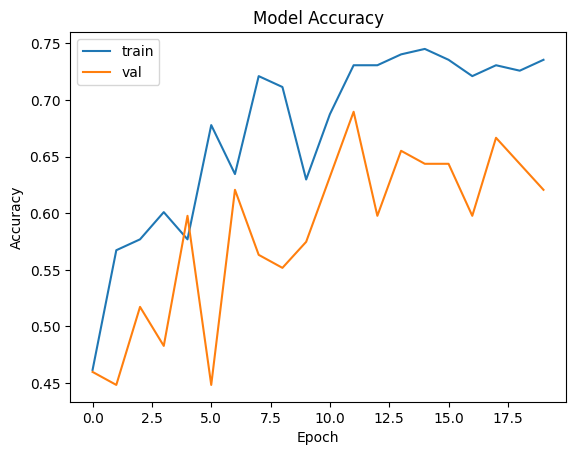

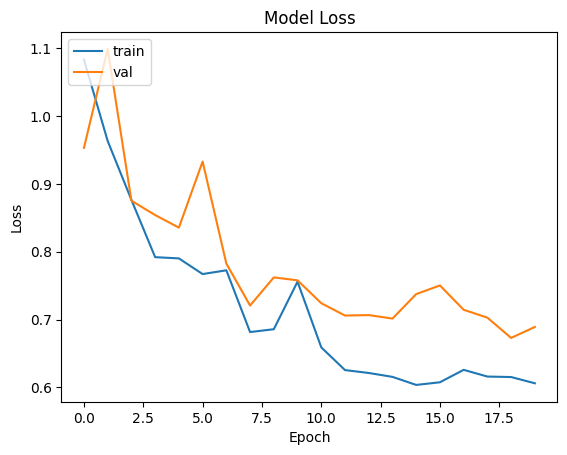

In [ ]:
import matplotlib.pyplot as plt


# Get the training and validation metrics over epochs
acc3 = history.history['accuracy']
val_acc3 = history.history['val_accuracy']
loss3 = history.history['loss']
val_loss3 = history.history['val_loss']

# Plot accuracy over epochs
plt.plot(acc3)
plt.plot(val_acc3)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot loss over epochs
plt.plot(loss3)
plt.plot(val_loss3)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, cohen_kappa_score
from sklearn.metrics import classification_report

test_pred = model3.predict(test_batches)
test_labels = test_batches.classes

acc = accuracy_score(test_labels, np.argmax(test_pred, axis=-1))

prec = precision_score(test_labels, np.argmax(test_pred, axis=-1), average='weighted')

f1 = f1_score(test_labels, np.argmax(test_pred, axis=-1), average='weighted')

sensitivity = recall_score(test_labels, np.argmax(test_pred, axis=-1), average='weighted')

auc = roc_auc_score(test_batches.labels, test_pred, multi_class='ovr', average='weighted')

kappa = cohen_kappa_score(test_labels, np.argmax(test_pred, axis=-1))

print(classification_report(test_labels, np.argmax(test_pred, axis=-1)))
print("Accuracy is found to be :",acc)
print("Precision is found to be :",prec)
print("F1 is found to be :",f1)
print("Sensitivity is found to be :",sensitivity)
print("AuC is found to be :",auc)
print("Kappa is found to be :",kappa)

6/6 [==============================] - 8s 1s/step
              precision    recall  f1-score   support

           0       0.50      0.24      0.33        29
           1       0.83      0.83      0.83        12
           2       0.62      0.83      0.71        46

    accuracy                           0.63        87
   macro avg       0.65      0.63      0.62        87
weighted avg       0.61      0.63      0.60        87

Accuracy is found to be : 0.632183908045977
Precision is found to be : 0.6109854908611269
F1 is found to be : 0.5990202030043444
Sensitivity is found to be : 0.632183908045977
AuC is found to be : 0.7586973824553941
Kappa is found to be : 0.3391882269166865


## Comparing the performance of the models

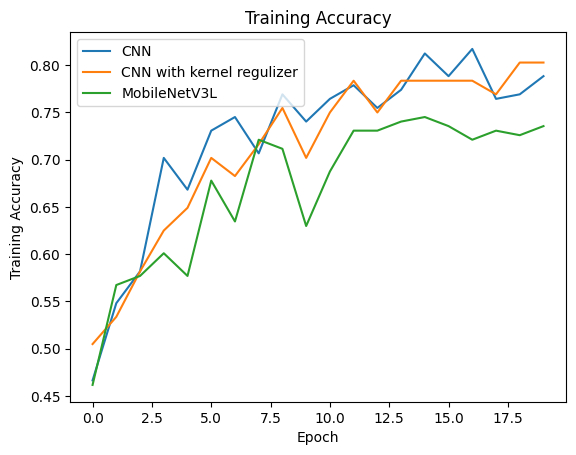

In [ ]:
# Plot accuracy over epochs
plt.plot(accu1)
plt.plot(acc2)
plt.plot(acc3)
plt.title('Training Accuracy')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.legend(['CNN', 'CNN with kernel regulizer','MobileNetV3L'], loc='upper left')
plt.show()

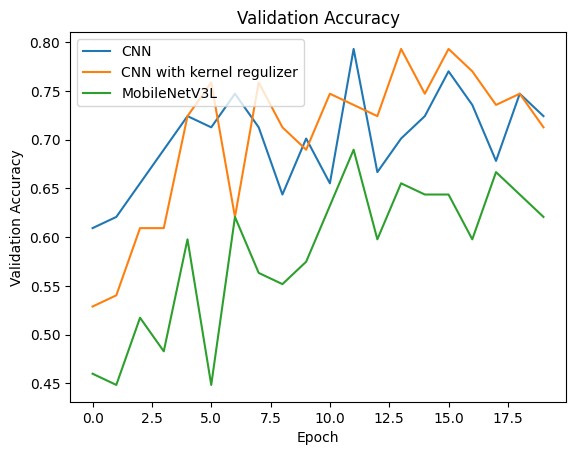

In [ ]:
# Plot accuracy over epochs
plt.plot(val_acc1)
plt.plot(val_acc2)
plt.plot(val_acc3)
plt.title('Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['CNN', 'CNN with kernel regulizer','MobileNetV3L'], loc='upper left')
plt.show()

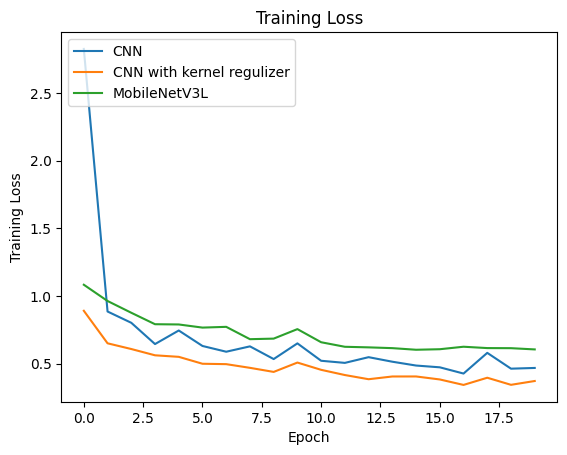

In [ ]:
# Plot accuracy over epochs
plt.plot(loss1)
plt.plot(loss2)
plt.plot(loss3)
plt.title('Training Loss')
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.legend(['CNN', 'CNN with kernel regulizer','MobileNetV3L'], loc='upper left')
plt.show()

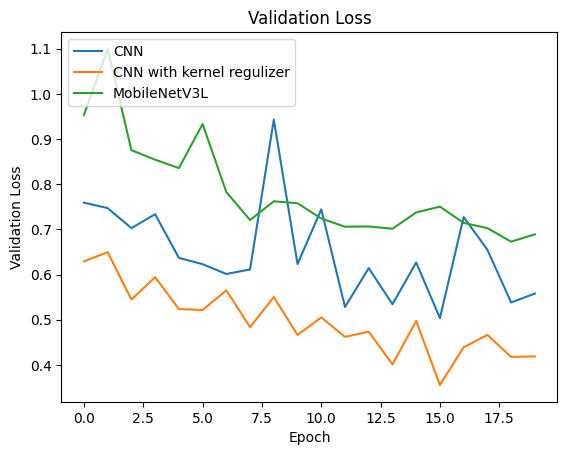

In [ ]:
# Plot accuracy over epochs
plt.plot(val_loss1)
plt.plot(val_loss2)
plt.plot(val_loss3)
plt.title('Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend(['CNN', 'CNN with kernel regulizer','MobileNetV3L'], loc='upper left')
plt.show()

### Ensemble model

In [ ]:
# Make predictions with both models
preds1 = model.predict(test_batches)
preds2 = model2.predict(test_batches)
preds3 = model3.predict(test_batches)


test_labels = test_batches.classes

preds_binary1 = (preds1 > 0.5).astype(int)
preds_binary2 = (preds2 > 0.5).astype(int)
preds_binary3 = (preds3 > 0.5).astype(int)

# Combine predictions using averaging
ensemble_preds_binary = (2*preds_binary1 + 4*preds_binary2 + 1*preds_binary3) / 7

6/6 [==============================] - 6s 906ms/step


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, cohen_kappa_score
from sklearn.metrics import classification_report

acc = accuracy_score(test_labels, np.argmax(ensemble_preds_binary, axis=-1))

prec = precision_score(test_labels, np.argmax(ensemble_preds_binary, axis=-1), average='weighted')

f1 = f1_score(test_labels, np.argmax(ensemble_preds_binary, axis=-1), average='weighted')

sensitivity = recall_score(test_labels, np.argmax(ensemble_preds_binary, axis=-1), average='weighted')

#auc = roc_auc_score(test_batches.labels, ensemble_preds_binary, multi_class='ovr', average='weighted')

kappa = cohen_kappa_score(test_labels, np.argmax(ensemble_preds_binary, axis=-1))

print(classification_report(test_labels, np.argmax(ensemble_preds_binary, axis=-1)))
print("Accuracy is found to be :",acc)
print("Precision is found to be :",prec)
print("F1 is found to be :",f1)
print("Sensitivity is found to be :",sensitivity)
#print("AuC is found to be :",auc)
print("Kappa is found to be :",kappa)

              precision    recall  f1-score   support

           0       0.67      0.48      0.56        29
           1       1.00      1.00      1.00        12
           2       0.72      0.85      0.78        46

    accuracy                           0.75        87
   macro avg       0.80      0.78      0.78        87
weighted avg       0.74      0.75      0.74        87

Accuracy is found to be : 0.7471264367816092
Precision is found to be : 0.7420178799489144
F1 is found to be : 0.7370114942528736
Sensitivity is found to be : 0.7471264367816092
Kappa is found to be : 0.5581717451523545
